In [2]:
'''''
%pip install konlpy
%pip install C:/Users/minsu/Downloads/mecab_python-0.996_ko_0.9.2_msvc-cp39-cp39-win_amd64.whl
%pip install pandas
%pip install matplotlib

# 오류해결을 위해 버전 설정
! pip install --upgrade pip
! pip install --upgrade jupyter notebook
! pip install pyLDAvis
! pip install --upgrade gensim
! pip install -U -q pyLDAvis==3.4.1

# 패키지 설치
! pip install nltk
nltk.download('averaged_perceptron_tagger') # pos tagging
nltk.download('stopwords') # stopword
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

# 오류해결을 위해 버전 설정
%pip install -U -q pyLDAvis==3.4.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -*- coding: utf-8 -*-
from konlpy.tag import Mecab
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [1]:
import pandas as pd

df = pd.read_csv("naver_news.csv")
df.dropna(subset = ['text'],axis=0,inplace=True)
df

platform category1 category2                                     title  \
1          네이버     생활/문화      사건사고                        당뇨환자가 치주질환에 취약한 이유   
3          네이버     생활/문화   자동차/시승기          낮엔 공무원·주말엔 주민이 탄다…기아, 전기차 공유 서비스   
4          네이버     생활/문화   자동차/시승기        기아, 발 막 다시 디뎠는데..中 전기차 시장, 난공불락 됐나   
5          네이버     생활/문화     패션/뷰티                 신세계인터 에스아이빌리지, 선물하기 혜택 강화   
6          네이버     생활/문화         책                 [신간 ]박희준 시집 ‘안 봐도 비디오’ 출간   
...        ...       ...       ...                                       ...   
12881      네이버     생활/문화     패션/뷰티        브랜드 빠진 '조용한 럭셔리'…29CM "'올드머니룩' 부상"   
12882      네이버     생활/문화     패션/뷰티        LF 불리, '클래식 오 트리쁠' 워터 베이스 향수 4종 출시   
12883      네이버     생활/문화        날씨  [오늘의 날씨] 제주(15일, 화)…가끔 소나기, 낮 최고 31도 무더위   
12884      네이버     생활/문화        날씨           [날씨] 전남 해안 호우주의보...남부 최대 150mm↑   
12885      네이버     생활/문화     음식/맛집           [피플] 호텔 중식의 대중화를 꿈꾼다… 황진선 진진 셰프   

        press writer       date_upload          date_fix  \
1       스포츠서울    황철훈  2023-09-18 18:40               NaN   
3        한국경제    배성수  2023-09-18 16:58  2023-09-18 17:00   
4        이데일리    이다원  2023-09-18 17:00               NaN   
5        데일리안    이나영  2023-09-18 00:44               NaN   
6      파이낸셜뉴스    노진균  2023-09-18 15:23               NaN   
...       ...    ...               ...               ...   
12881    연합뉴스    전성훈  2023-08-09 11:10  2023-08-09 11:11   
12882     뉴스1    김진희  2023-08-09 09:17  2023-08-09 09:18   
12883     뉴스1    오현지  2023-08-15 05:00  2023-08-15 05:00   
12884     YTN    NaN  2023-07-12 01:47  2023-07-12 02:01   
12885     머니S    박찬규  2023-06-23 06:00  2023-06-23 06:02   

                                                     url  \
1      https://n.news.naver.com/mnews/article/468/000...   
3      https://n.news.naver.com/mnews/article/015/000...   
4      https://n.news.naver.com/mnews/article/018/000...   
5      https://n.news.naver.com/mnews/article/119/000...   
6      https://n.news.naver.com/mnews/article/014/000...   
...                                                  ...   
12881  https://n.news.naver.com/mnews/article/001/001...   
12882  https://n.news.naver.com/mnews/article/421/000...   
12883  https://n.news.naver.com/mnews/article/421/000...   
12884  https://n.news.naver.com/mnews/article/052/000...   
12885  https://n.news.naver.com/mnews/article/417/000...   

                                                 sticker  \
1      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
3      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
4      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
5      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
6      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
...                                                  ...   
12881  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12882  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12883  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12884  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12885  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   

                                                    text  
1      [스포츠서울 | 황철훈기자] 치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생...  
3      기아는 강원도 홍천군과 함께 전기차 공유 서비스 '위블 비즈'를 시작한다고 18일 ...  
4      [이데일리 이다원 기자] 고속 성장 중인 중국 전기차 시장의 ‘자국 중심주의’가 확...  
5      [데일리안 = 이나영 기자] 신세계인터내셔날의 자체 디지털 플랫폼 에스아이빌리지는 ...  
6      [파이낸셜뉴스] "'안 봐도 비디오'는 아이가 짓고 있던 무궁무진한 무표정이다. 네...  
...                                                  ...  
12881  (서울=연합뉴스) 전성훈 기자 = 무신사의 온라인 편집숍 29CM는 은근하게 고급스...  
12882  (서울=뉴스1) 김진희 기자 = LF(093050)가 수입·판매하는 프랑스 향수 브...  
12883  (제주=뉴스1) 오현지 기자 = 15일 제주는 구름이 많겠고, 최고 체감온도가 33...  
12884  [앵커]\n전남 지방에 빗줄기가 강해지면서 호우주의보가 내려졌습니다.\n남부 지방은...  
12885  "왕육성 셰프는 인생의 스승이죠. 배움에 끝이 없는 게 요리가 아닐까 싶은데, 제 ...  

[12497 rows x 11 columns]

In [3]:
content_list = df["text"].tolist()
content_list

['[스포츠서울 | 황철훈기자] 치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생기는 것으로 구강 내 세균 증식이 원인이다. 그 외에도 흡연, 전신질환, 스트레스, 유전, 영양 상태 등 복합적인 요인이 치주질환의 위험 인자로 작용한다. 특히 지속적인 염증은 치주조직을 파괴하는 치주염으로 악화해 이를 뽑아야 하는 상황도 벌어진다.\n경희대치과병원 치주과 홍지연 교수는 “당뇨병의 혈중 고혈당 상태(고혈당증)는 단백질과 지방의 당화 및 산화를 유발하고, 최종당화산물(AGEs)을 축적해 여러 합병증을 일으키는 원인으로 작용한다”며 “당뇨병이 치주염의 염증 반응을 촉진하고 잇몸뼈를 흡수시켜 잇몸 건강을 악화할 수 있다”고 말했다.\n이어 “반대로 치주염이 당뇨병과 합병증을 악화시키는 위험 인자로 작용한다는 보고도 있다”며 “치주염이 심한 경우, 염증성 물질이나 세균성 산물이 혈류를 통해 전신적으로 퍼져나가 인슐린의 작용을 방해하고 당뇨병에 의한 대사장애가 악화할 수도 있다”고 덧붙였다.\n흔히 당뇨병이 있으면 치과 치료를 받지 못한다고 생각하지만 혈당 조절만 된다면 대부분 치과 치료를 받을 수 있다. 만약 혈당 조절이 되지 않는다면, 내과 협진을 통해 혈당을 안정시킨 후 치료를 받을 수 있다. 특히 치주질환의 치료와 예방은 구강 건강의 개선뿐 아니라 혈당 조절 측면에서도 도움이 될 수 있으므로 적극적으로 치료를 받는 것이 좋다.\n홍지연 교수는 “많은 분들이 치주염 잇몸 치료를 한 번 받고 나면 다시 문제가 생길 때까지 치과에 갈 필요가 없다고 생각하지만 치주염은 만성질환으로, 정기적인 검진과 스케일링을 통해 꾸준히 유지관리를 해야 한다”고 강조했다.\n치주염을 예방하기 위해서는 먼저 올바른 칫솔질을 익혀야 한다. 잇몸이 약할 경우에는 치아와 잇몸의 경계부에 칫솔모를 비스듬히 45도로 두고 가벼운 압력으로 진동을 주듯 짧고 부드럽게 움직이며 음식물 찌꺼기를 털어내는 칫솔법이 효과적이다.\n칫솔을 선택할 때, 칫솔 머리의 크기는 치아 2~3개를 덮을 정도가 적당하고

In [4]:
from bs4 import BeautifulSoup as bs

string_list = [ bs(i, "html.parser").get_text() for i in content_list ] # remove html tag > 순수한 text만 가져옴
string_list

C:\Users\minsu\AppData\Local\Temp\ipykernel_10956\2287731694.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  string_list = [ bs(i, "html.parser").get_text() for i in content_list ] # remove html tag > 순수한 text만 가져옴


['[스포츠서울 | 황철훈기자] 치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생기는 것으로 구강 내 세균 증식이 원인이다. 그 외에도 흡연, 전신질환, 스트레스, 유전, 영양 상태 등 복합적인 요인이 치주질환의 위험 인자로 작용한다. 특히 지속적인 염증은 치주조직을 파괴하는 치주염으로 악화해 이를 뽑아야 하는 상황도 벌어진다.\n경희대치과병원 치주과 홍지연 교수는 “당뇨병의 혈중 고혈당 상태(고혈당증)는 단백질과 지방의 당화 및 산화를 유발하고, 최종당화산물(AGEs)을 축적해 여러 합병증을 일으키는 원인으로 작용한다”며 “당뇨병이 치주염의 염증 반응을 촉진하고 잇몸뼈를 흡수시켜 잇몸 건강을 악화할 수 있다”고 말했다.\n이어 “반대로 치주염이 당뇨병과 합병증을 악화시키는 위험 인자로 작용한다는 보고도 있다”며 “치주염이 심한 경우, 염증성 물질이나 세균성 산물이 혈류를 통해 전신적으로 퍼져나가 인슐린의 작용을 방해하고 당뇨병에 의한 대사장애가 악화할 수도 있다”고 덧붙였다.\n흔히 당뇨병이 있으면 치과 치료를 받지 못한다고 생각하지만 혈당 조절만 된다면 대부분 치과 치료를 받을 수 있다. 만약 혈당 조절이 되지 않는다면, 내과 협진을 통해 혈당을 안정시킨 후 치료를 받을 수 있다. 특히 치주질환의 치료와 예방은 구강 건강의 개선뿐 아니라 혈당 조절 측면에서도 도움이 될 수 있으므로 적극적으로 치료를 받는 것이 좋다.\n홍지연 교수는 “많은 분들이 치주염 잇몸 치료를 한 번 받고 나면 다시 문제가 생길 때까지 치과에 갈 필요가 없다고 생각하지만 치주염은 만성질환으로, 정기적인 검진과 스케일링을 통해 꾸준히 유지관리를 해야 한다”고 강조했다.\n치주염을 예방하기 위해서는 먼저 올바른 칫솔질을 익혀야 한다. 잇몸이 약할 경우에는 치아와 잇몸의 경계부에 칫솔모를 비스듬히 45도로 두고 가벼운 압력으로 진동을 주듯 짧고 부드럽게 움직이며 음식물 찌꺼기를 털어내는 칫솔법이 효과적이다.\n칫솔을 선택할 때, 칫솔 머리의 크기는 치아 2~3개를 덮을 정도가 적당하고

In [5]:
import re # regex
only_BMP_pattern = re.compile("["u"\U00010000-\U0010FFFF"  #BMP characters 이외
                           "]+", flags=re.UNICODE)

# 적용
filter_list = []
for i in string_list:
    i = re.sub("[;0-9ㄱ-ㅎㅏ-ㅢ+\()/^!%※\xa0=~:\n\.{2,}]+", ' ', i).strip()
    i = re.sub(only_BMP_pattern, '', i)# BMP characters만
    i = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', i)
    i = re.sub(r'[0-9-]', '',i)
    i = re.sub('헤럴드경제|서울뉴시스|뉴시스|연합뉴스|서울 뉴시스|서울연합뉴스|영상편집|윤종희|권창회|기자|재판매|및|DB|금지|옮김|△|송광호|김용래|박재연임철휘|한문철TV|유튜브 채널|최원혁', '', i)
    i = re.sub('|'.join(df['press'].dropna().unique()), '', i)
    i = re.sub('|'.join(df['writer'].dropna().unique()), '', i)
    filter_list.append(i)

filter_list = [ i.replace(u"\xa0", u"") for i in filter_list ]
filter_list

<>:8: DeprecationWarning: invalid escape sequence \(
<>:10: DeprecationWarning: invalid escape sequence \?
<>:8: DeprecationWarning: invalid escape sequence \(
<>:10: DeprecationWarning: invalid escape sequence \?
C:\Users\minsu\AppData\Local\Temp\ipykernel_10956\1701563957.py:8: DeprecationWarning: invalid escape sequence \(
  i = re.sub("[;0-9ㄱ-ㅎㅏ-ㅢ+\()/^!%※\xa0=~:\n\.{2,}]+", ' ', i).strip()
C:\Users\minsu\AppData\Local\Temp\ipykernel_10956\1701563957.py:10: DeprecationWarning: invalid escape sequence \?
  i = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', i)


['      치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생기는 것으로 구강 내 세균 증식이 원인이다  그 외에도 흡연  전신질환  스트레스  유전  영양 상태 등 복합적인 요인이 치주질환의 위험 인자로 작용한다  특히 지속적인 염증은 치주조직을 파괴하는 치주염으로 악화해 이를 뽑아야 하는 상황도 벌어진다 경희대치과병원 치주과  교수는  당뇨병의 혈중 고혈당 상태 고혈당증 는 단백질과 지방의 당화  산화를 유발하고  최종당화산물 AGEs 을 축적해 여러 합병증을 일으키는 원인으로 작용한다 며  당뇨병이 치주염의 염증 반응을 촉진하고 잇몸뼈를 흡수시켜 잇몸 건강을 악화할 수 있다 고 말했다 이어  반대로 치주염이 당뇨병과 합병증을 악화시키는 위험 인자로 작용한다는 보고도 있다 며  치주염이 심한 경우  염증성 물질이나 세균성 산물이 혈류를 통해 전신적으로 퍼져나가 인슐린의 작용을 방해하고 당뇨병에 의한 대사장애가 악화할 수도 있다 고 덧붙였다 흔히 당뇨병이 있으면 치과 치료를 받지 못한다고 생각하지만 혈당 조절만 된다면 대부분 치과 치료를 받을 수 있다  만약 혈당 조절이 되지 않는다면  내과 협진을 통해 혈당을 안정시킨 후 치료를 받을 수 있다  특히 치주질환의 치료와 예방은 구강 건강의 개선뿐 아니라 혈당 조절 측면에서도 도움이 될 수 있으므로 적극적으로 치료를 받는 것이 좋다  교수는  많은 분들이 치주염 잇몸 치료를 한 번 받고 나면 다시 문제가 생길 때까지 치과에 갈 필요가 없다고 생각하지만 치주염은 만성질환으로  정기적인 검진과 스케일링을 통해 꾸준히 유지관리를 해야 한다 고 강조했다 치주염을 예방하기 위해서는 먼저 올바른 칫솔질을 익혀야 한다  잇몸이 약할 경우에는 치아와 잇몸의 경계부에 칫솔모를 비스듬히  도로 두고 가벼운 압력으로 진동을 주듯 짧고 부드럽게 움직이며 음식물 찌꺼기를 털어내는 칫솔법이 효과적이다 칫솔을 선택할 때  칫솔 머리의 크기는 치아  개를 덮을 정도가 적당하고 잇몸 상태에 따라 보통 또는 부드러운 칫솔모를 선택하면 

In [6]:
import nltk
from nltk import word_tokenize
from nltk.tag import pos_tag
from nltk import WordNetLemmatizer
from konlpy.tag import Mecab


with open("basic_stopword.txt", "r", encoding="utf-8") as f: #Encoding Type Error #euckr , cp949, utf-16
    stopword = f.read()

stopword_list = stopword.split()
wlem = WordNetLemmatizer() # nltk -> Lemmatize 단어의 원형을 갖고 오는 패키지 (Historical-> History)


# 토큰화 및 선별 _ 3자리 이상의 명사들만 추출하도록 선별
tokenizer = Mecab()
topic_list = []

for i in filter_list:
    alive_list = []
    for pos in (tokenizer.pos(i)):
        if (pos[1].startswith("N")) \
                and ("'" not in pos[0]):
                pre_keyword = pos[0].lower().strip() # pos_tagging -> keyword ( Wayne )
                if pre_keyword in stopword_list:
                    continue
                if len(pre_keyword) < 3:
                    continue
                keyword = wlem.lemmatize(pre_keyword) # keyword -> lemmatize -> keyword ( Wa )
                if len(keyword) < 3:
                    continue
                if keyword not in stopword_list:
                    alive_list.append(keyword)
    topic_list.append(alive_list)
    
    
topic_list

[['스트레스',
  '치주염',
  '경희대',
  '당뇨병',
  '고혈당증',
  '단백질',
  '합병증',
  '당뇨병',
  '치주염',
  '치주염',
  '당뇨병',
  '합병증',
  '치주염',
  '세균성',
  '인슐린',
  '당뇨병',
  '당뇨병',
  '대부분',
  '치주염',
  '치주염',
  '스케일링',
  '치주염',
  '칫솔질',
  '음식물',
  '찌꺼기'],
 ['강원도',
  '홍천군',
  '전기차',
  '서비스',
  '경기도',
  '화성시',
  '광명시',
  '경상남도',
  '홍천군',
  '친환경',
  '모빌리티',
  '출퇴근',
  '친환경',
  '서비스',
  '서비스',
  '대중교통',
  '지자체',
  '홍천군',
  '스마트',
  '공무원',
  '스마트',
  '스마트',
  '홍천군',
  '모빌리티',
  '서비스',
  '관계자',
  '공무원',
  '스마트',
  '구성원',
  '공무원',
  '모바일',
  '애플리케이션',
  '애플리케이션',
  '솔루션',
  '관계자',
  '서비스',
  '모빌리티',
  '서비스',
  '모빌리티',
  '솔루션'],
 ['전기차',
  '중심주의',
  '브랜드',
  '가운데',
  '브랜드',
  '점유율',
  '전기차',
  '경쟁력',
  '승용차',
  '판매량',
  '전기차',
  '플러그인',
  '하이브리드',
  '친환경',
  '에너지',
  '승용차',
  '친환경',
  '비야디',
  '승용차',
  '판매량',
  '전기차',
  '점유율',
  '플러그인',
  '하이브리드',
  '전기차',
  '광저우',
  '자동차',
  '전기차',
  '브랜드',
  '아이온',
  '자동차',
  '전기차',
  '스타트업',
  '샤오펑',
  '자동차',
  '자동차',
  '전기차',
  '생태계',
  '분위기',
  '요미우리',
  '전기차',
  '자동차',
  '친환경',
  

### 최적의 토픽값 찾기
1. perplexity _ 확률 모델이 결과를 얼마나 정확하게 예측하는지 판단
2. CoherenceModel _ 토픽이 얼마나 의미론적으로 일관성 있는지 판단

In [9]:
# corpus 만들기
scroe_reviews =  [[y for y in x if not len(y)==1] for x in topic_list]
dictionary = corpora.Dictionary(scroe_reviews)
corpus = [dictionary.doc2bow(text) for text in scroe_reviews] # doc2bow문서데이터 수치화

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 5),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 7),
  (12, 1),
  (13, 2)],
 [(14, 1),
  (15, 1),
  (16, 1),
  (17, 3),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 4),
  (24, 6),
  (25, 2),
  (26, 4),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 4),
  (33, 1)],
 [(18, 1),
  (28, 21),
  (31, 3),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 3),
  (45, 6),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 5),
  (52, 1),
  (53, 1),
  (54, 2),
  (55, 1),
  (56, 6),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 6),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 2)],
 [(18, 1),
  (24, 7),
  (45, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 5),
  (81, 2),
  (82, 2),
  (83, 1),
  (84, 2),
  (85

In [9]:
## 멀티코어

from gensim.models import CoherenceModel
import gensim as gs #gensim
import pyLDAvis.gensim_models

peplexity_values = []
coherence_values = []

k_start_value = 2
k_end_value = 15
passes_value = 100
iteration_value = 1000

for i in tqdm(range(k_start_value, k_end_value+1)):
    print(i)
    beta_value = 1 / k_start_value
    lda_model = gs.models.ldamulticore.LdaMulticore(corpus, num_topics=i, id2word=dictionary, chunksize=2000,
                                            passes=passes_value, iterations=iteration_value,
                                            eta=beta_value, eval_every=None, per_word_topics=True, workers=12)
    # 퍼블렉서티
    peplexity_values.append(lda_model.log_perplexity(corpus)) # 대부분 마이너스 값이 나와 유의미하지 않음
    
    # coherence
    coherence_model_lda = CoherenceModel(model=lda_model,texts=scroe_reviews,dictionary=dictionary,topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

  0%|          | 0/14 [00:00<?, ?it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [14]:
## 단일코어
# perplexity 측정
# Coherence Model 측정
from gensim.models import CoherenceModel
import gensim as gs #gensim
import pyLDAvis.gensim_models

peplexity_values = []
coherence_values = []

k_start_value = 2
k_end_value = 15
passes_value = 100
iteration_value = 1000

for i in tqdm(range(k_start_value, k_end_value+1)):
    print(i)
    beta_value = 1 / k_start_value
    lda_model = gs.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, chunksize=2000,
                                            passes=passes_value, iterations=iteration_value,
                                            eta=beta_value, eval_every=None, per_word_topics=True)
    # 퍼블렉서티
    peplexity_values.append(lda_model.log_perplexity(corpus)) # 대부분 마이너스 값이 나와 유의미하지 않음
    
    # coherence
    coherence_model_lda = CoherenceModel(model=lda_model,texts=scroe_reviews,dictionary=dictionary,topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

  0%|          | 0/14 [00:00<?, ?it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [19]:
peplexity_values, coherence_values

([-8.563934997055254,
  -8.410315368276102,
  -8.367391435155383,
  -8.309606969910458,
  -8.273795880575735,
  -8.253176448871402,
  -8.243842364292798,
  -8.23036431429382,
  -8.275492422097388,
  -8.237463707282782,
  -8.235033761079485,
  -8.223692719223342,
  -8.226469744955857,
  -8.212803993385029],
 [0.4519535059341604,
  0.5570671105691667,
  0.5362308767450723,
  0.5454858685183481,
  0.6224032376643053,
  0.5395584513917232,
  0.6454522874781117,
  0.6786255986873984,
  0.5355471497552811,
  0.5945104865752694,
  0.5691222412310281,
  0.5974815089907702,
  0.6069752146263518,
  0.6065584843662251])

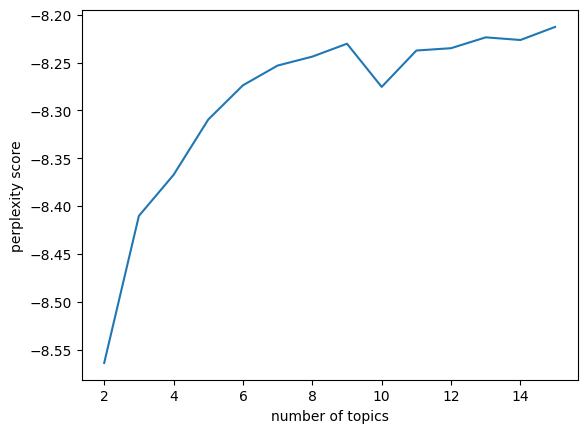

In [16]:
# 퍼블렉서티 시각화
x = range(k_start_value, k_end_value+1)
plt.plot(x,peplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

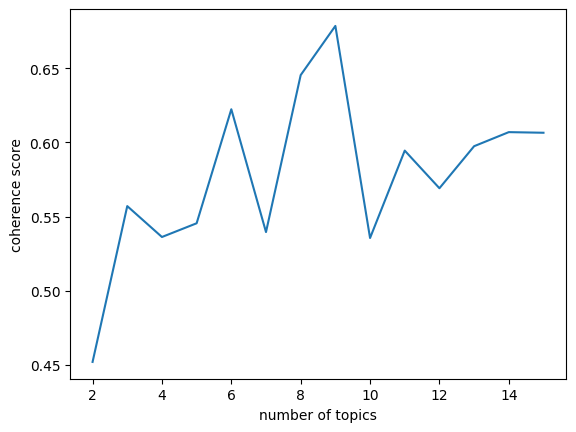

In [17]:
# coherence 시각화
x = range(k_start_value, k_end_value+1)
plt.plot(x,coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

### 최적값으로 토픽 모델링 진행

In [20]:
gs_dict = gs.corpora.Dictionary(topic_list)
gs_corpus = [gs_dict.doc2bow(text) for text in topic_list ]

alpha_value = [0.01, 0.03, 0.1, 0.3, 0.5, 0.7]  #러닝레이트
k_start_value = 2
k_end_value = 15 # k는 토픽의 범위를 담당합니다. start ~ end
# beta 값은 1/k 로 계산합니다.
passes_value = 100
iteration_value = 1000

for alpha in alpha_value:
    print(alpha)
    beta_value = 1 / k_start_value
    lda_model = gs.models.ldamodel.LdaModel(gs_corpus, num_topics=6, id2word=gs_dict, chunksize=10000, update_every=1, passes=passes_value, iterations=iteration_value, alpha=alpha, eta=beta_value, eval_every=None, per_word_topics=True)
    #lda_model = gs.models.ldamulticore.LdaMulticore(gs_corpus, num_topics=i, id2word=gs_dict, chunksize=2000,
    #                                        passes=passes_value, iterations=iteration_value,
    #                                        alpha=alpha, eta=beta_value, eval_every=None, per_word_topics=True, workers=12)

    coherence_model_lda = gs.models.CoherenceModel(model=lda_model, texts=topic_list, dictionary=gs_dict, coherence='c_v', topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    lda_model.print_topics()
    lda_visual = pyLDAvis.gensim_models.prepare(lda_model, gs_corpus, gs_dict)
    # pyLDAvis.save_html(lda_visual, "./gensim_data/" + "alpha" + f"_{alpha}" + f"_topic_{i}_{coherence_lda}" + ".html")
    pyLDAvis.save_html(lda_visual, f"./gensim/alpha" + f"_{alpha}" + f"_topic_6_{coherence_lda}" + ".html")

In [80]:
pickle.dump(gs_corpus, open('lda_corpus.pkl', 'wb'))
dictionary.save('lda_dictionary.gensim')
lda_model.save('lda_model.gensim')

### 결과 다시 임포트

In [7]:
from gensim import models
from gensim import corpora
import pickle
import gensim as gs #gensim
import pyLDAvis.gensim_models


# lda_model을 다시 로드
loaded_lda_model = models.LdaModel.load('lda_model.gensim')
loaded_lda_model


# 저장된 pickle 파일을 로드합니다.
with open('lda_corpus.pkl', 'rb') as file:
    loaded_gs_corpus = pickle.load(file)

# 저장된 dictionary를 로드합니다.
loaded_dictionary = corpora.Dictionary.load('lda_dictionary.gensim')
loaded_dictionary

In [19]:
lda_visual = pyLDAvis.gensim_models.prepare(loaded_lda_model, loaded_gs_corpus, loaded_dictionary)
lda_visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.004037  0.076967       1        1  21.428304
5     -0.137031 -0.041563       2        1  19.987859
3     -0.188048 -0.094180       3        1  19.350993
0      0.003820  0.099494       4        1  14.230864
2      0.207450 -0.200932       5        1  13.958565
1      0.109772  0.160213       6        1  11.043416, topic_info=       Term         Freq        Total Category  logprob  loglift
14654   하나님  3610.000000  3610.000000  Default  30.0000  30.0000
28      전기차  2060.000000  2060.000000  Default  29.0000  29.0000
56      자동차  2027.000000  2027.000000  Default  28.0000  28.0000
24      서비스  2496.000000  2496.000000  Default  27.0000  27.0000
38      글로벌  1850.000000  1850.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
377     어려움   184.903799   444.905531   Topic6  -5.6324   1.3253
390  

# 토픽모델링을 통한 본격 기능 구현

### 문서별 토픽 할당

In [8]:
tokenized_list

[['스트레스',
  '치주염',
  '경희대',
  '당뇨병',
  '고혈당증',
  '단백질',
  '합병증',
  '당뇨병',
  '치주염',
  '치주염',
  '당뇨병',
  '합병증',
  '치주염',
  '세균성',
  '인슐린',
  '당뇨병',
  '당뇨병',
  '대부분',
  '치주염',
  '치주염',
  '스케일링',
  '치주염',
  '칫솔질',
  '음식물',
  '찌꺼기'],
 ['강원도',
  '홍천군',
  '전기차',
  '서비스',
  '경기도',
  '화성시',
  '광명시',
  '경상남도',
  '홍천군',
  '친환경',
  '모빌리티',
  '출퇴근',
  '친환경',
  '서비스',
  '서비스',
  '대중교통',
  '지자체',
  '홍천군',
  '스마트',
  '공무원',
  '스마트',
  '스마트',
  '홍천군',
  '모빌리티',
  '서비스',
  '관계자',
  '공무원',
  '스마트',
  '구성원',
  '공무원',
  '모바일',
  '애플리케이션',
  '애플리케이션',
  '솔루션',
  '관계자',
  '서비스',
  '모빌리티',
  '서비스',
  '모빌리티',
  '솔루션'],
 ['전기차',
  '중심주의',
  '브랜드',
  '가운데',
  '브랜드',
  '점유율',
  '전기차',
  '경쟁력',
  '승용차',
  '판매량',
  '전기차',
  '플러그인',
  '하이브리드',
  '친환경',
  '에너지',
  '승용차',
  '친환경',
  '비야디',
  '승용차',
  '판매량',
  '전기차',
  '점유율',
  '플러그인',
  '하이브리드',
  '전기차',
  '광저우',
  '자동차',
  '전기차',
  '브랜드',
  '아이온',
  '자동차',
  '전기차',
  '스타트업',
  '샤오펑',
  '자동차',
  '자동차',
  '전기차',
  '생태계',
  '분위기',
  '요미우리',
  '전기차',
  '자동차',
  '친환경',
  

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tokenized_list = topic_list

# 토큰화된 텍스트 데이터를 문자열로 결합
tokenized_text = [' '.join(tokens) for tokens in tokenized_list]

# CountVectorizer를 적용
count_vectorizer = CountVectorizer(max_df=0.1, max_features=1000, min_df=2, ngram_range=(1,2))
feat_vect = count_vectorizer.fit_transform(tokenized_text)
print('CountVectorizer Shape:', feat_vect.shape)

lda = LatentDirichletAllocation(n_components=6)  # 토픽 수는 6개로 설정
lda.fit(feat_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=6, n_jobs=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

CountVectorizer Shape: (12497, 1000)


LatentDirichletAllocation(n_components=6)

In [11]:
def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

# CountVectorizer 객체 내의 전체 word들의 명칭을 get_feature_names_out()를 통해 추출
feature_names = count_vectorizer.get_feature_names_out()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topics(lda, feature_names, 10)

Topic # 0
하나님 기독교 코로나 프로그램 하나님 하나님 아버지 청소년 화장품 공동체 미술관
Topic # 1
컬렉션 디자인 스타일 클래식 글로벌 오케스트라 프랑스 이탈리아 아이템 지휘자
Topic # 2
소비자 서비스 온라인 콘텐츠 관광객 뮤지컬 프로그램 이벤트 외국인 코로나
Topic # 3
기상청 소나기 제주도 대부분 미세먼지 미술관 강수량 박물관 어린이 앞바다
Topic # 4
전기차 자동차 현대차 배터리 디자인 글로벌 시스템 판매량 모빌리티 타이어
Topic # 5
서비스 에너지 단백질 스트레스 시스템 서울시 전문가 비타민 대중교통 치료제


### 문서별 토픽 할당

# 문서별로, 가장 확률이 높은 topic으로 할당해줌

In [13]:
# 데이터프레임
df = df.reset_index(drop=True)
df

platform category1 category2                                     title  \
0          네이버     생활/문화      사건사고                        당뇨환자가 치주질환에 취약한 이유   
1          네이버     생활/문화   자동차/시승기          낮엔 공무원·주말엔 주민이 탄다…기아, 전기차 공유 서비스   
2          네이버     생활/문화   자동차/시승기        기아, 발 막 다시 디뎠는데..中 전기차 시장, 난공불락 됐나   
3          네이버     생활/문화     패션/뷰티                 신세계인터 에스아이빌리지, 선물하기 혜택 강화   
4          네이버     생활/문화         책                 [신간 ]박희준 시집 ‘안 봐도 비디오’ 출간   
...        ...       ...       ...                                       ...   
12492      네이버     생활/문화     패션/뷰티        브랜드 빠진 '조용한 럭셔리'…29CM "'올드머니룩' 부상"   
12493      네이버     생활/문화     패션/뷰티        LF 불리, '클래식 오 트리쁠' 워터 베이스 향수 4종 출시   
12494      네이버     생활/문화        날씨  [오늘의 날씨] 제주(15일, 화)…가끔 소나기, 낮 최고 31도 무더위   
12495      네이버     생활/문화        날씨           [날씨] 전남 해안 호우주의보...남부 최대 150mm↑   
12496      네이버     생활/문화     음식/맛집           [피플] 호텔 중식의 대중화를 꿈꾼다… 황진선 진진 셰프   

        press writer       date_upload          date_fix  \
0       스포츠서울    황철훈  2023-09-18 18:40               NaN   
1        한국경제    배성수  2023-09-18 16:58  2023-09-18 17:00   
2        이데일리    이다원  2023-09-18 17:00               NaN   
3        데일리안    이나영  2023-09-18 00:44               NaN   
4      파이낸셜뉴스    노진균  2023-09-18 15:23               NaN   
...       ...    ...               ...               ...   
12492    연합뉴스    전성훈  2023-08-09 11:10  2023-08-09 11:11   
12493     뉴스1    김진희  2023-08-09 09:17  2023-08-09 09:18   
12494     뉴스1    오현지  2023-08-15 05:00  2023-08-15 05:00   
12495     YTN    NaN  2023-07-12 01:47  2023-07-12 02:01   
12496     머니S    박찬규  2023-06-23 06:00  2023-06-23 06:02   

                                                     url  \
0      https://n.news.naver.com/mnews/article/468/000...   
1      https://n.news.naver.com/mnews/article/015/000...   
2      https://n.news.naver.com/mnews/article/018/000...   
3      https://n.news.naver.com/mnews/article/119/000...   
4      https://n.news.naver.com/mnews/article/014/000...   
...                                                  ...   
12492  https://n.news.naver.com/mnews/article/001/001...   
12493  https://n.news.naver.com/mnews/article/421/000...   
12494  https://n.news.naver.com/mnews/article/421/000...   
12495  https://n.news.naver.com/mnews/article/052/000...   
12496  https://n.news.naver.com/mnews/article/417/000...   

                                                 sticker  \
0      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
1      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
2      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
3      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
4      {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
...                                                  ...   
12492  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12493  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12494  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12495  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12496  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   

                                                    text  
0      [스포츠서울 | 황철훈기자] 치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생...  
1      기아는 강원도 홍천군과 함께 전기차 공유 서비스 '위블 비즈'를 시작한다고 18일 ...  
2      [이데일리 이다원 기자] 고속 성장 중인 중국 전기차 시장의 ‘자국 중심주의’가 확...  
3      [데일리안 = 이나영 기자] 신세계인터내셔날의 자체 디지털 플랫폼 에스아이빌리지는 ...  
4      [파이낸셜뉴스] "'안 봐도 비디오'는 아이가 짓고 있던 무궁무진한 무표정이다. 네...  
...                                                  ...  
12492  (서울=연합뉴스) 전성훈 기자 = 무신사의 온라인 편집숍 29CM는 은근하게 고급스...  
12493  (서울=뉴스1) 김진희 기자 = LF(093050)가 수입·판매하는 프랑스 향수 브...  
12494  (제주=뉴스1) 오현지 기자 = 15일 제주는 구름이 많겠고, 최고 체감온도가 33...  
12495  [앵커]\n전남 지방에 빗줄기가 강해지면서 호우주의보가 내려졌습니다.\n남부 지방은...  
12496  "왕육성 셰프는 인생의 스승이죠. 배움에 끝이 없는 게 요리가 아닐까 싶은데, 제 ...  

[12497 rows x 11 columns]

In [14]:
doc_topic = lda.transform(feat_vect)

doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic_pr = doc_topic[n].max()
    doc_per_topic_list.append([n, topic_most_pr, topic_pr])
    
doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=['Doc_Num', 'Topic', 'Percentage'])

doc_topic_df

Doc_Num  Topic  Percentage
0            0      3    0.498319
1            1      5    0.913305
2            2      4    0.989290
3            3      2    0.865800
4            4      3    0.930213
...        ...    ...         ...
12492    12492      2    0.624280
12493    12493      1    0.489267
12494    12494      3    0.924223
12495    12495      3    0.828647
12496    12496      0    0.585426

[12497 rows x 3 columns]

In [15]:
doc_topic_df = pd.merge(df, doc_topic_df, left_index=True, right_index=True, how='inner')
doc_topic_df = doc_topic_df[['Topic','category2','url','title','text','press','date_upload','sticker','Percentage']]
doc_topic_df

Topic category2                                                url  \
0          3      사건사고  https://n.news.naver.com/mnews/article/468/000...   
1          5   자동차/시승기  https://n.news.naver.com/mnews/article/015/000...   
2          4   자동차/시승기  https://n.news.naver.com/mnews/article/018/000...   
3          2     패션/뷰티  https://n.news.naver.com/mnews/article/119/000...   
4          3         책  https://n.news.naver.com/mnews/article/014/000...   
...      ...       ...                                                ...   
12492      2     패션/뷰티  https://n.news.naver.com/mnews/article/001/001...   
12493      1     패션/뷰티  https://n.news.naver.com/mnews/article/421/000...   
12494      3        날씨  https://n.news.naver.com/mnews/article/421/000...   
12495      3        날씨  https://n.news.naver.com/mnews/article/052/000...   
12496      0     음식/맛집  https://n.news.naver.com/mnews/article/417/000...   

                                          title  \
0                            당뇨환자가 치주질환에 취약한 이유   
1              낮엔 공무원·주말엔 주민이 탄다…기아, 전기차 공유 서비스   
2            기아, 발 막 다시 디뎠는데..中 전기차 시장, 난공불락 됐나   
3                     신세계인터 에스아이빌리지, 선물하기 혜택 강화   
4                     [신간 ]박희준 시집 ‘안 봐도 비디오’ 출간   
...                                         ...   
12492        브랜드 빠진 '조용한 럭셔리'…29CM "'올드머니룩' 부상"   
12493        LF 불리, '클래식 오 트리쁠' 워터 베이스 향수 4종 출시   
12494  [오늘의 날씨] 제주(15일, 화)…가끔 소나기, 낮 최고 31도 무더위   
12495           [날씨] 전남 해안 호우주의보...남부 최대 150mm↑   
12496           [피플] 호텔 중식의 대중화를 꿈꾼다… 황진선 진진 셰프   

                                                    text   press  \
0      [스포츠서울 | 황철훈기자] 치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생...   스포츠서울   
1      기아는 강원도 홍천군과 함께 전기차 공유 서비스 '위블 비즈'를 시작한다고 18일 ...    한국경제   
2      [이데일리 이다원 기자] 고속 성장 중인 중국 전기차 시장의 ‘자국 중심주의’가 확...    이데일리   
3      [데일리안 = 이나영 기자] 신세계인터내셔날의 자체 디지털 플랫폼 에스아이빌리지는 ...    데일리안   
4      [파이낸셜뉴스] "'안 봐도 비디오'는 아이가 짓고 있던 무궁무진한 무표정이다. 네...  파이낸셜뉴스   
...                                                  ...     ...   
12492  (서울=연합뉴스) 전성훈 기자 = 무신사의 온라인 편집숍 29CM는 은근하게 고급스...    연합뉴스   
12493  (서울=뉴스1) 김진희 기자 = LF(093050)가 수입·판매하는 프랑스 향수 브...     뉴스1   
12494  (제주=뉴스1) 오현지 기자 = 15일 제주는 구름이 많겠고, 최고 체감온도가 33...     뉴스1   
12495  [앵커]\n전남 지방에 빗줄기가 강해지면서 호우주의보가 내려졌습니다.\n남부 지방은...     YTN   
12496  "왕육성 셰프는 인생의 스승이죠. 배움에 끝이 없는 게 요리가 아닐까 싶은데, 제 ...     머니S   

            date_upload                                            sticker  \
0      2023-09-18 18:40  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
1      2023-09-18 16:58  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
2      2023-09-18 17:00  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
3      2023-09-18 00:44  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
4      2023-09-18 15:23  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
...                 ...                                                ...   
12492  2023-08-09 11:10  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12493  2023-08-09 09:17  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12494  2023-08-15 05:00  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12495  2023-07-12 01:47  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12496  2023-06-23 06:00  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   

       Percentage  
0        0.498319  
1        0.913305  
2        0.989290  
3        0.865800  
4        0.930213  
...           ...  
12492    0.624280  
12493    0.489267  
12494    0.924223  
12495    0.828647  
12496    0.585426  

[12497 rows x 9 columns]

In [16]:
doc_topic_df.to_csv("doc_topic_df.csv",index=False)

In [20]:
doc_topic_df[doc_topic_df['Topic']==3]

Topic category2                                                url  \
0          3      사건사고  https://n.news.naver.com/mnews/article/468/000...   
4          3         책  https://n.news.naver.com/mnews/article/014/000...   
5          3         책  https://n.news.naver.com/mnews/article/469/000...   
6          3        날씨  https://n.news.naver.com/mnews/article/119/000...   
8          3  생활/문화 일반  https://n.news.naver.com/mnews/article/023/000...   
...      ...       ...                                                ...   
12469      3   자동차/시승기  https://n.news.naver.com/mnews/article/018/000...   
12486      3      사건사고  https://n.news.naver.com/mnews/article/011/000...   
12490      3      사건사고  https://n.news.naver.com/mnews/article/469/000...   
12494      3        날씨  https://n.news.naver.com/mnews/article/421/000...   
12495      3        날씨  https://n.news.naver.com/mnews/article/052/000...   

                                               title  \
0                                 당뇨환자가 치주질환에 취약한 이유   
4                          [신간 ]박희준 시집 ‘안 봐도 비디오’ 출간   
5      고양이도, 책도 좋다면 ... 국내 최초 고양이 북페어 '냥냥북페어' 현장을 가다   
6                        [내일날씨] 전국 흐리고 일부 비…아침 안개 유의   
8          단역서 봉준호의 배우까지...75세에 칸 레드카펫 밟은 변희봉의 연기 인생   
...                                              ...   
12469      국내 최고 환경전문검사 출신 변호사 “현장은 멀었다…ESG 공시 신중해야”   
12486            국민배우 변희봉 췌장암 투병 끝 별세…조기발견 방법은[헬시타임]   
12490              전립선암, 최근 5년새 40% 증가… 벌써 '남성 암' 3위   
12494       [오늘의 날씨] 제주(15일, 화)…가끔 소나기, 낮 최고 31도 무더위   
12495                [날씨] 전남 해안 호우주의보...남부 최대 150mm↑   

                                                    text   press  \
0      [스포츠서울 | 황철훈기자] 치주질환은 잇몸이나 잇몸뼈와 같은 치주조직에 염증이 생...   스포츠서울   
4      [파이낸셜뉴스] "'안 봐도 비디오'는 아이가 짓고 있던 무궁무진한 무표정이다. 네...  파이낸셜뉴스   
5      "이거 봐. 정말 귀엽다!"\n16일, 서울 마포구 마포아트센터의 갤러리 공간. 벽...    한국일보   
6      [데일리안 = 정진주 기자] 화요일인 19일 전국 대부분이 흐리고 일부 지역 비가 ...    데일리안   
8      영화 ‘살인의 추억’(2003)과 ‘괴물’(2006) 등에 출연한 ‘봉준호의 배우’...    조선일보   
...                                                  ...     ...   
12469  [이데일리 김경은 기자] “ESG(환경·사회·지배구조)가 점점 ‘법(Hard law...    이데일리   
12486  [서울경제]\n원로배우 변희봉(본명 변인철)이 18일 향년 81세로 별세했다. 고인...    서울경제   
12490  9월 셋째 주는 전립선암에 대한 올바른 인식을 확립하고 조기 검진 확대를 위해 제정...    한국일보   
12494  (제주=뉴스1) 오현지 기자 = 15일 제주는 구름이 많겠고, 최고 체감온도가 33...     뉴스1   
12495  [앵커]\n전남 지방에 빗줄기가 강해지면서 호우주의보가 내려졌습니다.\n남부 지방은...     YTN   

            date_upload                                            sticker  \
0      2023-09-18 18:40  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
4      2023-09-18 15:23  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
5      2023-09-18 15:26  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
6      2023-09-18 19:59  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
8      2023-09-18 21:57  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
...                 ...                                                ...   
12469  2023-09-18 17:31  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12486  2023-09-18 19:36  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12490  2023-09-18 22:41  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12494  2023-08-15 05:00  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   
12495  2023-07-12 01:47  {'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...   

       Percentage  
0        0.498319  
4        0.930213  
5        0.875906  
6        0.930530  
8        0.947701  
...           ...  
12469    0.612567  
12486    0.890163  
12490    0.977800  
12494    0.924223  
12495    0.828647  

[2650 rows x 9 columns]